# Single-qubit gate layer learning procedure
The following notebook demonstrates the single qubit layer learning package, designed to be an extensible implementation that can be adapted to different languages and system architectures. This package provides an implementation of a fidelity learning procedure for single qubit,
along with some extra visualization and debugging tools.

The structure is designed like the qiskit_experiments package. There are two classes:

1. The experiment class
2. The analysis class

The experiment class is used to generate the circuits necessary to benchmark a layer of single-
qubit gates. The class implements the following functionalities
- Use backend coupling map to generate the nine pauli measurements (Following fig. S3)
- Construct a gate dictionary to compile circuits with uniform noise
- Generate single instance of twirled circuits with corresponding metadata (Following fig. S1)
    - Implement basis change
    - Add k layers of pauli twirling
    - Change to computational basis
    - Twirl readout in Z basis
    - Compile adjacent gates such that
        - SPAM errors are minimized
        - Noise on gates is uniform 
    - Generate all circuits required to benchmark layer with corresponding metadata
    
The analysis class takes in counts from qiskit.providers.ibmq.job.result().get_counts() and
the associated metadata to find the fidelities and generate the model coefficients. The class
is a counterpart to the experiment class and can be initialized from an instance of the
experiment class. This class implements the following features:
    
- extracting the error model from the backend and computing twirled channel fidelities
- generating a list of paulis in the sparse model bases on backend topology
- converting single shot into expectation value using readout twirling and pauli metadata
- processing experiment data to create fidelity list and compute model coefficients
- generate graphs of exponential fits vs circuit depth
- create graphs of measured fidelities vs predicted fidelities
- show graph of measured model coefficients vs predicted coefficients

In [2]:
from qiskit.providers.aer import AerSimulator #get simulator of backend
from qiskit.providers.fake_provider import FakeQuito #choice of fake backend
from multiprocessing.pool import ThreadPool
from itertools import product

#Import the experiment and analysis classes for the procedure
from learning_procedures import SingleGateLayerAnalysis, SingleGateLayerExperiment

## Initialize procedure

In [3]:
#The backend used is a qiskit backend because it provides the basis gates, coupling map, and number of qubits.
#This information could easily be imported or entered manually, circumventing the need for a IBMQBackend
backend = AerSimulator.from_backend(FakeQuito())
#experiment class
experiment = SingleGateLayerExperiment([1,2,4], #qubits containing gates
                                         backend, #backend for noise model/basis gates
                                         samples = 200, #number of samples of twirl
                                         depths = [2,4,8,16,32,64,128] #depths to measure
                                         )

#analysis class is initialized from experiment class
analysis = SingleGateLayerAnalysis.fromExperiment(experiment)

## Generate circuits and metadata
This currently uses qiskit circuits. The actual circuit instances are originally represented as strings, and translated into qiskit using a dictionary. This dictionary could also be used to translate the string representations to circuits in quil

In [6]:
#This method generates circuits and metadata containing the repetitions of noise,
#readout twirl, and pauli basis
circuits, data = experiment.generate_measurement_circuits()

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


## Run circuits and collect data
As in pygsti, the user is responsible for running the circuits generated on the desired backend and returning the data as a counts dictionary.

In [ ]:
#run a circuit on backend simulator and return counts
run = lambda qc: backend.run(qc, shots = 250).result().get_counts()

with ThreadPool(12) as pool:
    results = pool.map(run, circuits)

## Analyze data
The `process_data` method packages all of the analysis into one method. This method collects the data from the circuit runs, performs the exponential fit, extracts the fidelities, and solves for the model coefficients. The results are returned and also stored in `analysis.ordered_data`

In [172]:
# package results with metadata and send to analysis method
results_data = analysis.process_data(results, data)

## Plot data
The analysis class computes the ideal fidelities from the reported processor noise model, and can generate several graphs to compare them with the measured fidelities.

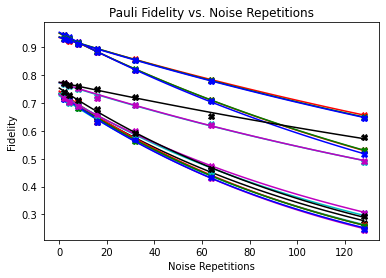

In [173]:
analysis.plot_fits(subset = None)

/home/ben/.local/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


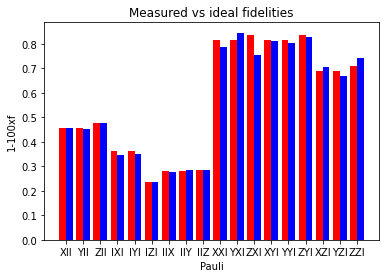

In [174]:
analysis.plot_fidelities(subset = None)

/home/ben/.local/lib/python3.10/site-packages/scipy/optimize/_nnls.py:80: ComplexWarning: Casting complex values to real discards the imaginary part
  x, rnorm, mode = __nnls.nnls(A, m, n, b, w, zz, index, maxiter)


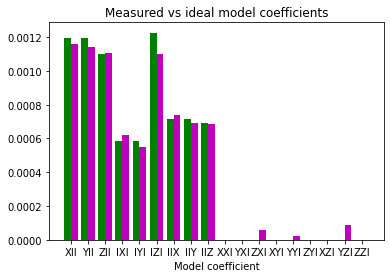

In [175]:
analysis.plot_model_coeffs(subset = None) 

The above graphs reveals that the qiskit fake backend simulators only implement local noise models without crosstalk. Since all of the gates are single-qubit gates, there are no two-qubit interactions.

## Class walkthrough
The next few cells give a walkthrough of the functionalities of the classes.

### Pauli string generattion
Only nine pauli bases need to be measured to fully reconstruct the sparse model. The paper provides a sweeping algorithm which is implemented in the experiment class. This algorithm uses the backend topology to determine the connectivity of the qubits in the layer, and determines the strings such that every qubit has each pauli operator at least once, and every qubit pair has each of the nine pauli bases once.

This algorithm will work on any processor that can be iterated through such that each new vertex visited is not connected to more than two vertices which have already been visited. This encompasses both square and heavy-hex processors.

In [16]:
#set up an example experiment
experiment = SingleGateLayerExperiment([0,1,2], backend, samples = 1, depths = [1,2,4])
adjacency = experiment.get_connectivity()
print("Adjacency Matrix:", adjacency)

Adjacency Matrix: ([[0, 1, 0], [1, 0, 1], [0, 1, 0]], [1, 2, 1])


In [6]:
#print the pauli strings that need data
experiment.get_pauli_strings()

['XXX', 'YXY', 'ZXZ', 'XYX', 'YYY', 'ZYZ', 'XZX', 'YZY', 'ZZZ']

Generate a circuit instance in the pauli+H+S gate set

In [7]:
circuit, basis, repetitions, rotwirl = experiment.generate_single_instance(basis_operator="XYZ",noise_repetitions=3,transpiled=False)
print("Basis:", basis)
print("Repetitions:", repetitions)
print("Readout twirl:", rotwirl)
circuit.draw()

Basis: XYZ
Repetitions: 3
Readout twirl: 010


┌───┐┌───┐      ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ┌───┐           
q_0: ┤ H ├┤ X ├──────░─┤ Z ├─░─┤ I ├─░─┤ Y ├─┤ H ├───────────
     ├───┤├───┤┌───┐ ░ ├───┤ ░ ├───┤ ░ ├───┤┌┴───┴┐┌───┐┌───┐
q_1: ┤ H ├┤ S ├┤ X ├─░─┤ X ├─░─┤ Y ├─░─┤ Y ├┤ Sdg ├┤ H ├┤ X ├
     ├───┤└───┘└───┘ ░ ├───┤ ░ ├───┤ ░ ├───┤└─────┘└───┘└───┘
q_2: ┤ Y ├───────────░─┤ I ├─░─┤ Z ├─░─┤ X ├─────────────────
     └───┘           ░ └───┘ ░ └───┘ ░ └───┘

Some of the issues with the built-in transpilation routines are explored in `transpiler_passes.ipynb`. This class implements transpilation by generating the necessary gates, pre-transpiling them for the native gate set, and labeling them with a unique string. In addition, `id` gates are compiled into the circuit so that qubits experience noise during idle, and `RZ` gates, implemented as noiseless, delay-free frame rotations, are compiled with an `id` gate so that the noise is uniform.

In [8]:
circuit, basis, repetitions, rotwirl = experiment.generate_single_instance(basis_operator="XYZ",noise_repetitions=3,transpiled=True)
print("Basis:", basis)
print("Repetitions:", repetitions)
print("Readout twirl:", rotwirl)
circuit.draw()

Basis: XYZ
Repetitions: 3
Readout twirl: 110


global phase: π/2
     ┌─────────┐ ┌────┐┌─────────┐ ░   ┌───┐         ░ ┌────────┐┌───┐ ░ »
q_0: ┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├─░───┤ I ├─────────░─┤ Rz(-π) ├┤ X ├─░─»
     ├─────────┴┐├────┤└┬────────┤ ░ ┌─┴───┴──┐┌───┐ ░ └─┬───┬──┘└───┘ ░ »
q_1: ┤ Rz(-π/2) ├┤ √X ├─┤ Rz(-π) ├─░─┤ Rz(-π) ├┤ X ├─░───┤ X ├─────────░─»
     └──┬───┬───┘└────┘ └────────┘ ░ └─┬───┬──┘└───┘ ░   ├───┤         ░ »
q_2: ───┤ I ├──────────────────────░───┤ X ├─────────░───┤ X ├─────────░─»
        └───┘                      ░   └───┘         ░   └───┘         ░ »
q_3: ──────────────────────────────░─────────────────░─────────────────░─»
                                   ░                 ░                 ░ »
q_4: ──────────────────────────────░─────────────────░─────────────────░─»
                                   ░                 ░                 ░ »
c: 5/════════════════════════════════════════════════════════════════════»
                                                                         »
«     ┌─────────┐   ┌────┐   ┌──────────┐ ░ ┌─┐      
«q_0: ┤ Rz(π/2) ├───┤ √X ├───┤ Rz(-π/2) ├─░─┤M├──────
«     └──┬────┬─┘┌──┴────┴──┐└──────────┘ ░ └╥┘┌─┐   
«q_1: ───┤ √X ├──┤ Rz(-π/2) ├─────────────░──╫─┤M├───
«        ├───┬┘  └──────────┘             ░  ║ └╥┘┌─┐
«q_2: ───┤ I ├────────────────────────────░──╫──╫─┤M├
«        └───┘                            ░  ║  ║ └╥┘
«q_3: ────────────────────────────────────░──╫──╫──╫─
«                                         ░  ║  ║  ║ 
«q_4: ────────────────────────────────────░──╫──╫──╫─
«                                         ░  ║  ║  ║ 
«c: 5/═══════════════════════════════════════╩══╩══╩═
«                                            0  1  2

The dictionary for converting between the transpiled and non-transpiled gates can be printed with the following method:

In [9]:
experiment.print_gate_conversions().draw()

global phase: 2π
      ┌───┐                  ░    ┌───┐                            
 q_0: ┤ I ├──────────────────░────┤ I ├────────────────────────────
      ├───┤                  ░    ├───┤                            
 q_1: ┤ X ├──────────────────░────┤ X ├────────────────────────────
      ├───┤                  ░  ┌─┴───┴──┐    ┌───┐                
 q_2: ┤ Y ├──────────────────░──┤ Rz(-π) ├────┤ X ├────────────────
      ├───┤                  ░  ├───────┬┘    ├───┤                
 q_3: ┤ Z ├──────────────────░──┤ Rz(π) ├─────┤ I ├────────────────
      ├───┤ ┌───┐            ░ ┌┴───────┴┐    ├───┴┐   ┌─────────┐ 
 q_4: ┤ H ├─┤ I ├────────────░─┤ Rz(π/2) ├────┤ √X ├───┤ Rz(π/2) ├─
      ├───┤ ├───┤            ░ ├─────────┴┐   ├────┤   ├─────────┤ 
 q_5: ┤ H ├─┤ X ├────────────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π/2) ├─
      ├───┤ ├───┤            ░ ├──────────┤   ├────┤   ├─────────┴┐
 q_6: ┤ H ├─┤ Y ├────────────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π/2) ├
      ├───┤ ├───┤            ░ ├─────────┬┘   ├────┤   ├──────────┤
 q_7: ┤ H ├─┤ Z ├────────────░─┤ Rz(π/2) ├────┤ √X ├───┤ Rz(-π/2) ├
      ├───┤ ├───┤ ┌───┐      ░ ├─────────┤    ├────┤   └┬────────┬┘
 q_8: ┤ H ├─┤ S ├─┤ I ├──────░─┤ Rz(π/2) ├────┤ √X ├────┤ Rz(-π) ├─
      ├───┤ ├───┤ ├───┤      ░ ├─────────┴┐   ├────┤    └────────┘ 
 q_9: ┤ H ├─┤ S ├─┤ X ├──────░─┤ Rz(-π/2) ├───┤ √X ├───────────────
      ├───┤ ├───┤ ├───┤      ░ ├──────────┤   ├────┤    ┌────────┐ 
q_10: ┤ H ├─┤ S ├─┤ Y ├──────░─┤ Rz(-π/2) ├───┤ √X ├────┤ Rz(-π) ├─
      ├───┤ ├───┤ ├───┤      ░ ├─────────┬┘   ├────┤    └────────┘ 
q_11: ┤ H ├─┤ S ├─┤ Z ├──────░─┤ Rz(π/2) ├────┤ √X ├───────────────
      ├───┤ ├───┤ └───┘      ░ └──┬───┬──┘    └────┘               
q_12: ┤ I ├─┤ X ├────────────░────┤ X ├────────────────────────────
      ├───┤ ├───┤            ░ ┌──┴───┴──┐    ┌────┐   ┌─────────┐ 
q_13: ┤ I ├─┤ H ├────────────░─┤ Rz(π/2) ├────┤ √X ├───┤ Rz(π/2) ├─
      ├───┤ ├───┤ ┌───┐      ░ ├─────────┴┐   ├────┤   ├─────────┤ 
q_14: ┤ I ├─┤ H ├─┤ X ├──────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π/2) ├─
      ├───┤┌┴───┴┐├───┤      ░ └──┬────┬──┘┌──┴────┴─┐ └─────────┘ 
q_15: ┤ I ├┤ Sdg ├┤ H ├──────░────┤ √X ├───┤ Rz(π/2) ├─────────────
      ├───┤├─────┤├───┤┌───┐ ░  ┌─┴────┴─┐ └──┬────┬─┘ ┌─────────┐ 
q_16: ┤ I ├┤ Sdg ├┤ H ├┤ X ├─░──┤ Rz(-π) ├────┤ √X ├───┤ Rz(π/2) ├─
      ├───┤└┬───┬┘└───┘└───┘ ░  └────────┘    └────┘   └─────────┘ 
q_17: ┤ X ├─┤ X ├────────────░─────────────────────────────────────
      ├───┤ ├───┤            ░ ┌─────────┐    ┌────┐   ┌──────────┐
q_18: ┤ X ├─┤ H ├────────────░─┤ Rz(π/2) ├────┤ √X ├───┤ Rz(-π/2) ├
      ├───┤ ├───┤ ┌───┐      ░ ├─────────┴┐   ├────┤   ├──────────┤
q_19: ┤ X ├─┤ H ├─┤ X ├──────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π/2) ├
      ├───┤┌┴───┴┐├───┤      ░ └┬────────┬┘   ├────┤   ├──────────┤
q_20: ┤ X ├┤ Sdg ├┤ H ├──────░──┤ Rz(-π) ├────┤ √X ├───┤ Rz(-π/2) ├
      ├───┤├─────┤├───┤┌───┐ ░  └─┬────┬─┘ ┌──┴────┴──┐└──────────┘
q_21: ┤ X ├┤ Sdg ├┤ H ├┤ X ├─░────┤ √X ├───┤ Rz(-π/2) ├────────────
      ├───┤└┬───┬┘└───┘└───┘ ░  ┌─┴────┴─┐ └──────────┘            
q_22: ┤ Y ├─┤ X ├────────────░──┤ Rz(-π) ├─────────────────────────
      ├───┤ ├───┤            ░ ┌┴────────┴┐   ┌────┐   ┌──────────┐
q_23: ┤ Y ├─┤ H ├────────────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π/2) ├
      ├───┤ ├───┤ ┌───┐      ░ ├─────────┬┘   ├────┤   ├──────────┤
q_24: ┤ Y ├─┤ H ├─┤ X ├──────░─┤ Rz(π/2) ├────┤ √X ├───┤ Rz(-π/2) ├
      ├───┤┌┴───┴┐├───┤      ░ └──┬────┬─┘ ┌──┴────┴──┐└──────────┘
q_25: ┤ Y ├┤ Sdg ├┤ H ├──────░────┤ √X ├───┤ Rz(-π/2) ├────────────
      ├───┤├─────┤├───┤┌───┐ ░  ┌─┴────┴─┐ └──┬────┬──┘┌──────────┐
q_26: ┤ Y ├┤ Sdg ├┤ H ├┤ X ├─░──┤ Rz(-π) ├────┤ √X ├───┤ Rz(-π/2) ├
      ├───┤└┬───┬┘└───┘└───┘ ░  ├───────┬┘    ├───┬┘   └──────────┘
q_27: ┤ Z ├─┤ X ├────────────░──┤ Rz(π) ├─────┤ X ├────────────────
      ├───┤ ├───┤            ░ ┌┴───────┴─┐   ├───┴┐   ┌─────────┐ 
q_28: ┤ Z ├─┤ H ├────────────░─┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π/2) ├─
      ├───┤ ├───┤ ┌───┐      ░ ├───────

### Generating an experiment
The following routine generates the circuits and metadata for the experiment based on the paramaters passed to the constructor of the class.

In [10]:
circs, metadata = experiment.generate_measurement_circuits()
for m in metadata:
    print(m)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 
{'basis': 'XXX', 'length': 1, 'rostring': '010'}
{'basis': 'XXX', 'length': 2, 'rostring': '010'}
{'basis': 'XXX', 'length': 4, 'rostring': '000'}
{'basis': 'YXY', 'length': 1, 'rostring': '000'}
{'basis': 'YXY', 'length': 2, 'rostring': '100'}
{'basis': 'YXY', 'length': 4, 'rostring': '101'}
{'basis': 'ZXZ', 'length': 1, 'rostring': '011'}
{'basis': 'ZXZ', 'length': 2, 'rostring': '001'}
{'basis': 'ZXZ', 'length': 4, 'rostring': '111'}
{'basis': 'XYX', 'length': 1, 'rostring': '010'}
{'basis': 'XYX', 'length': 2, 'rostring': '101'}
{'basis': 'XYX', 'length': 4, 'rostring': '101'}
{'basis': 'YYY', 'length': 1, 'rostring': '000'}
{'basis': 'YYY', 'length': 2, 'rostring': '110'}
{'basis': 'YYY', 'length': 4, 'rostring': '100'}
{'basis': 'ZYZ', 'length': 1, 'rostring': '101'}
{'basis': 'ZYZ', 'length': 2, 'rostring': '000'}
{'basis': 'ZYZ', 'length': 4, 'rostring': '101'}
{'basi

### Analysis class
The analysis class processes the data from an experiment. This next cell shows a routine for estimating the error model from the channels reported by the backend. The class parses all of the noisy instructions on single-qubit gates and averages them together to get an average error channel on each qubit.

In [11]:
analysis = SingleGateLayerAnalysis.fromExperiment(experiment)
errors = analysis.get_real_errors()
print(errors[0])

SuperOp([[1.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
          7.37293330e-04+0.j],
         [0.00000000e+00+0.j, 9.98675015e-01+0.j, 0.00000000e+00+0.j,
          0.00000000e+00+0.j],
         [0.00000000e+00+0.j, 0.00000000e+00+0.j, 9.98675015e-01+0.j,
          0.00000000e+00+0.j],
         [0.00000000e+00+0.j, 0.00000000e+00+0.j, 0.00000000e+00+0.j,
          9.99262707e-01+0.j]],
        input_dims=(2,), output_dims=(2,))


The transfer matrix of the twirled channel $S^{\mathbb{P}^n}$ is found by averaging the superoperator $S$ over conjugation by $P_i^\ast \otimes P_i$ for all $i \leq 4^n$. Since the error model is local, the fidelity of the two-qubit operators is a product of the fidelity of the single-qubit operators

In [15]:
transfer_matrix_diagonal = analysis.get_real_PTM()

print(list(transfer_matrix_diagonal[p+"II"] for p in "XYZ"))
print(list(transfer_matrix_diagonal[p*2+"I"] for p in "XYZ"))

[(0.9986750154413331+0j), (0.9986750154413331+0j), (0.9992627066704572+0j)]
[(0.9941100982211697+0j), (0.9941100982211697+0j), (0.9945046837521285+0j)]


The circuits can be run and then the corresponding data can be used by the analysis class to generate an expectation value from every circuit instance.

In [13]:
res = backend.run(circs).result().get_counts()
analysis.get_expectation(p="XXI", result = res[0], **metadata[0])

0.87890625

The values are not accurate because there was no twirling in this example, but the following shows how the analyzed data is reported.

In [14]:
from scipy.optimize import nnls
analysis.process_data(res, metadata)

{'XII': {1: {'expectation': 0.923828125, 'total': 3.0},
  2: {'expectation': 0.8984375, 'total': 3.0},
  4: {'expectation': 0.8919270833333334, 'total': 3.0},
  'fit': (0.9274426012777499, 0.010663732651470078),
  'fidelity': 0.9893929233784736,
  'coefficient': 0.9893929233784736},
 'YII': {1: {'expectation': 0.93359375, 'total': 3.0},
  2: {'expectation': 0.8977864583333334, 'total': 3.0},
  4: {'expectation': 0.857421875, 'total': 3.0},
  'fit': (0.9557042220430197, 0.027775209036696037),
  'fidelity': 0.9726069754886338,
  'coefficient': 0.9726069754886338},
 'ZII': {1: {'expectation': 0.935546875, 'total': 3.0},
  2: {'expectation': 0.9251302083333334, 'total': 3.0},
  4: {'expectation': 0.8951822916666666, 'total': 3.0},
  'fit': (0.9510051126258264, 0.014922744050162593),
  'fidelity': 0.9851880483015399,
  'coefficient': 0.9851880483015399},
 'IXI': {1: {'expectation': 0.9361979166666666, 'total': 3.0},
  2: {'expectation': 0.9440104166666666, 'total': 3.0},
  4: {'expectation'